<a href="https://colab.research.google.com/github/9characters/GAN_repo/blob/master/GAN_Fashion_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Dependencies
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
#Downloading all thhe data files into the colab
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [0]:
#Copy the downloaded files into the project folder
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

In [0]:
print(mnist)

In [0]:
#Training Parameters
learning_rate = 0.0002
batch_size = 128
epochs = 100000

In [0]:
#Network Parameters
image_dim = 784 #Image size is 28*28
gen_hidd_dim = 256 #No of hidden nodes
disc_hidd_dim = 256
z_noise_dim = 100

In [0]:
#Xavier Initialization
def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev=1./tf.sqrt(shape[0]/2.0))

In [0]:
#Define weights and bias dictionaries
weights = {"disc_H": tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
           "disc_final": tf.Variable(xavier_init([disc_hidd_dim, 1])),
           "gen_H": tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
           "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))}
           
bias = {"disc_H": tf.Variable(xavier_init([disc_hidd_dim])),
        "disc_final": tf.Variable(xavier_init([1])),
        "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
        "gen_final": tf.Variable(xavier_init([image_dim]))}

In [0]:
print(weights)

In [38]:
print(bias)

{'disc_H': <tf.Variable 'Variable_28:0' shape=(256,) dtype=float32_ref>, 'disc_final': <tf.Variable 'Variable_29:0' shape=(1,) dtype=float32_ref>, 'gen_H': <tf.Variable 'Variable_30:0' shape=(256,) dtype=float32_ref>, 'gen_final': <tf.Variable 'Variable_31:0' shape=(784,) dtype=float32_ref>}


In [0]:
#Creating Computational Graph
#Define Discriminator Function (Network)
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output

def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"])
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

In [0]:
#Define the placefolders for External Input
z_input = tf.placeholder(tf.float32, shape=[None, z_noise_dim], name="input_noise")
x_input = tf.placeholder(tf.float32, shape=[None, image_dim], name="real_input")

In [0]:
#Building Generator Network
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input)
# output_Gen will have the G(z)

In [69]:
print(output_Gen)

Tensor("Generator_9/Sigmoid:0", shape=(?, 784), dtype=float32)


In [0]:
#Building the Discriminator Network
with tf.name_scope("Discriminator") as scope:
  real_output1_Disc, real_output_Disc = Discriminator(x_input)      #Implements D(x)
  fake_output1_Disc, fake_output_Disc = Discriminator(output_Gen)    #Implements D(G(x))

In [0]:
#First Kind of Loss
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_Disc + 0.0001) + tf.log(1.-fake_output_Disc + 0.0001))

In [0]:
with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_Disc + 0.0001))

In [0]:
#Tensorboard Summary
Disc_loss_total = tf.summary.scalar("Disc_Total_Loss", Discriminator_Loss)
Gen_loss_total = tf.summary.scalar("Gen_Loss", Generator_Loss)

In [0]:
#Define Variables
Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

In [0]:
#Define the optimizer
with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Discriminator_Loss, var_list= Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Generator_Loss, var_list=Generator_var)

In [93]:
#Initialize the variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  x_batch, _ = mnist.train.next_batch(batch_size)

  #Generate noise to feed to the discriminator
  z_noise = np.random.uniform(-1., 1., size=[batch_size, z_noise_dim])
  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict={x_input: x_batch, z_input: z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict={z_input: z_noise})

  #Running the Discriminator Summary
  summary_Disc_Loss = sess.run(Disc_loss_total, feed_dict={x_input: x_batch, z_input: z_noise})

  #Adding the Discriminator Summary
  writer.add_summary(summary_Disc_Loss, epoch)

  #Running the Generator Summary
  summary_Gen_Loss = sess.run(Gen_loss_total, feed_dict={z_input: z_noise})

  #Adding the Generator Summary
  writer.add_summary(summary_Gen_Loss, epoch)

  if epoch%2000 == 0:
    print(f"Steps: {epoch}, Generator_Loss: {Gen_loss_epoch}, Discriminator_Loss: {Disc_loss_epoch}")

Steps: 0, Generator_Loss: 0.186140239238739, Discriminator_Loss: 2.6163723468780518
Steps: 2000, Generator_Loss: 2.4013962745666504, Discriminator_Loss: 0.32854941487312317
Steps: 4000, Generator_Loss: 2.777116060256958, Discriminator_Loss: 0.29510927200317383
Steps: 6000, Generator_Loss: 2.5436837673187256, Discriminator_Loss: 0.27354031801223755
Steps: 8000, Generator_Loss: 2.2192468643188477, Discriminator_Loss: 0.3408932089805603
Steps: 10000, Generator_Loss: 2.116610050201416, Discriminator_Loss: 0.5756590366363525
Steps: 12000, Generator_Loss: 2.3381457328796387, Discriminator_Loss: 0.47417837381362915
Steps: 14000, Generator_Loss: 2.347304105758667, Discriminator_Loss: 0.42164844274520874
Steps: 16000, Generator_Loss: 2.4300899505615234, Discriminator_Loss: 0.5183159708976746
Steps: 18000, Generator_Loss: 3.076122999191284, Discriminator_Loss: 0.6042883992195129
Steps: 20000, Generator_Loss: 2.4834914207458496, Discriminator_Loss: 0.47545403242111206
Steps: 22000, Generator_Loss

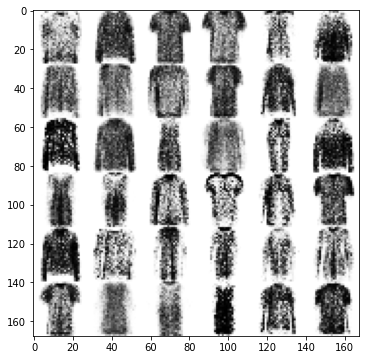

In [94]:
#Testing 
#Generate Images from noise using the generator network
n=6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1., 1., size=[batch_size, z_noise_dim])

  #Generate Input From Noise
  g = sess.run(output_Gen, feed_dict={z_input: z_noise})

  #Reverse colors for better display
  g  = -1 * (g-1)
  for j in range(n):
    #Fraw the generated images
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28,28])

plt.figure(figsize=(n,n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()   